# Plotting utilities

`xarrayutils` provides a bunch of small functions to adjust [matplotlib](https://matplotlib.org) plots.

## Setting multiple y axes to the same values range
Sometimes it is beneficial if the amplitude of a signal can be compared directly. If the mean of the signal is shifted, setting the absolute y limits doesnt work. `same_y_range` provides a quick fix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%load_ext autoreload
%autoreload 2

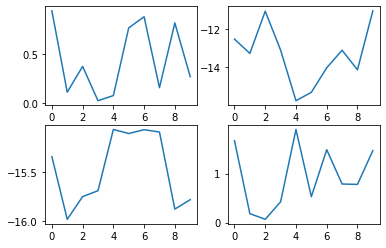

In [2]:
fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))


These are hard to compare with regard to their amplitude. 

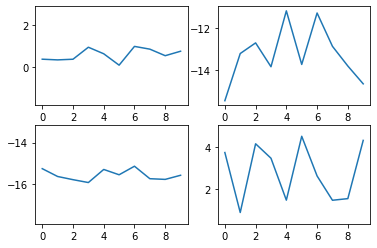

In [3]:
from xarrayutils.plotting import same_y_range

fig, axarr = plt.subplots(ncols=2, nrows=2)

# plot the same signal scaled and shifted or both
axarr.flat[0].plot(np.random.rand(10))
axarr.flat[1].plot((np.random.rand(10)*5)-16)
axarr.flat[2].plot((np.random.rand(10))-16)
axarr.flat[3].plot((np.random.rand(10)*5))

same_y_range(axarr)

Now we can clearly see the different amplitude. 

## shaded line plots

In [4]:
from xarrayutils.plotting import shaded_line_plot

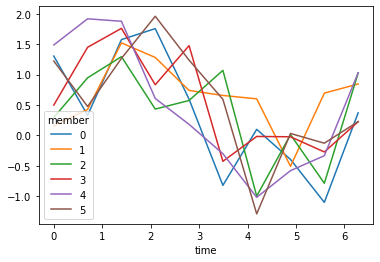

In [5]:
# build test dataset with noisy members
x = np.linspace(0,2*np.pi, 10)
y = np.sin(x)
y_full = np.stack([y+np.random.rand(len(y))*2-0.5 for e in range(6)])
da = xr.DataArray(y_full, coords=[('member',range(6)),('time',x)])
da.plot(hue='member');

Thats pretty cool (xarray is generally awesome!), but what if we have several of these datasets (e.g. climate models with several members each)?

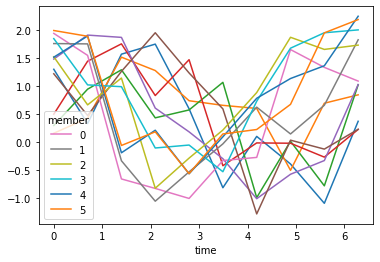

In [6]:
x = np.linspace(0,2*np.pi, 10)
y = np.sin(x+2)
y_full = np.stack([y+np.random.rand(len(y))*2-0.5 for e in range(6)])
da2 = xr.DataArray(y_full, coords=[('member',range(6)),('time',x)])
da.plot(hue='member')
da2.plot(hue='member');

Ok that is not great. We can color each dataset with a different color...

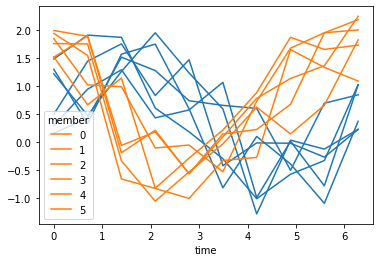

In [7]:
da.plot(hue='member', color='C0')
da2.plot(hue='member', color='C1');

But if you supply more models this ends up looking too busy. `xarrayutils.plotting.shaded_line_plot` give a quick alternative to show the spread of the members with a line and shaded envelope:

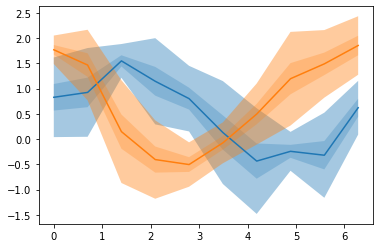

In [8]:
shaded_line_plot(da, 'member', color='C0');
shaded_line_plot(da2, 'member', color='C1');

In the default setting, this plots the mean along the dimension `member` as a line and the ranges indicate 1 standard deviation (dark shading) and 3 standard deviations (light shading). The transparency and spread values can be customized.

We can confirm this by tracing the shading with some more lines

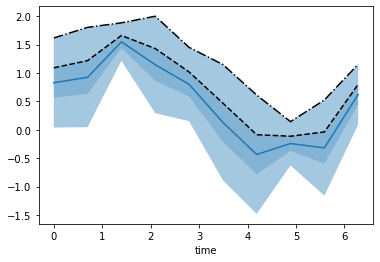

In [9]:
shaded_line_plot(da, 'member', color='C0')
(da.mean('member') + da.std('member') / 2).plot(color='k', ls='--')
(da.mean('member') + da.std('member') * 3 / 2).plot(color='k', ls='-.')


Lets add shading for 2, 3, and 5 standard deviations with different increasing alpha values (increasing alpha for increased transparency).

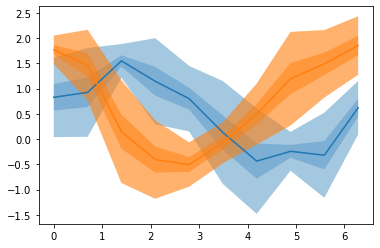

In [10]:
shaded_line_plot(da, 'member', spreads=[2,3,5], alphas=[0.1, 0.3, 0.4], color='C0');
shaded_line_plot(da2, 'member',spreads=[2,3,5], alphas=[0.2, 0.5, 0.6], color='C1');

Additionally `shaded_line_plot` offers a different mode to determine the spread, using quantiles.

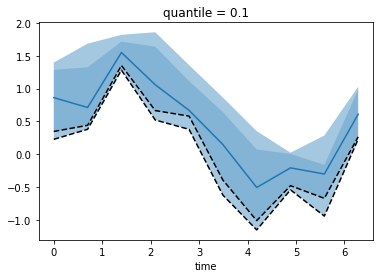

In [16]:
shaded_line_plot(da, 'member', spread_style='quantile', color='C0');
da.quantile(0.25,'member').plot(color='k', ls='--')
da.quantile(0.1,'member').plot(color='k', ls='--')

The default `spreads` value is `[0.5, 0.8]` which means the outer shading indicates the 25th and 75th percentile, and the inner one the 10th and 90th percentile. You can customize this just like before.

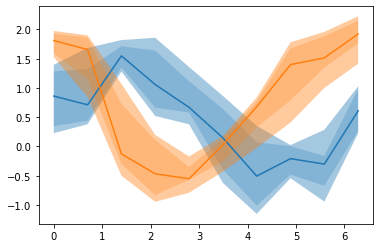

In [17]:
shaded_line_plot(da, 'member', spread_style='quantile', spreads=[0.5,1], color='C0');
shaded_line_plot(da2, 'member',spread_style='quantile', spreads=[0.5,1], color='C1');

Here the lines indicate the 50th quantile (approximate median), and the shadings indicate the range between the 25th and 75th percentile (dark) and the full range between 0th and 100th percentile (light

## Scale axis with two different linear scales
A widely used plot in oceanography is a North South section through an ocean basin. Lets plot an oxygen section in the central pacific from the [World Ocean Atlas](https://www.nodc.noaa.gov/OC5/woa18/)

In [ ]:
woa_path = 'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/oxygen/all/1.00/woa18_all_o00_01.nc'
woa = xr.open_dataset(woa_path, decode_times=False)
o2 = woa[['o_an']].squeeze(drop=True).o_an
o2.sel(lon=-180, method='nearest').plot(robust=True)
plt.gca().invert_yaxis()

You can see that there is a lot more structure to the oxygen field in the upper ~1000m, and less below. Yet the plot is visually dominated by the deep ocean. We can focus on the upper ocean by compressing the values below 1000 m using `linear_piecewise_scale`.

In [ ]:
from xarrayutils.plotting import linear_piecewise_scale

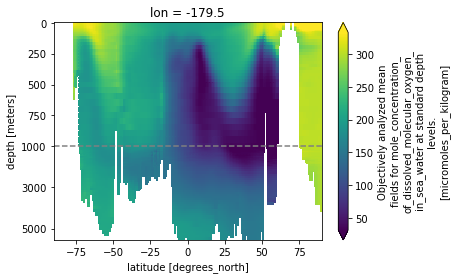

In [6]:
o2.sel(lon=-180, method='nearest').plot(robust=True)
ax = plt.gca()
ax.invert_yaxis()
linear_piecewise_scale(1000, 5)
#indicate the point between the different scalings
ax.axhline(1000, color='0.5', ls='--')
# Rearange the yticks
ax.set_yticks([0, 250, 500, 750, 1000, 3000, 5000]);

Now you can see the uppr ocean structure more clearly, without completely cutting out the deep ocean. We can adjust the `cut` (the point of the y-axis where the different linear scales meet) and the `scale` (higher numbers mean a stronger compression of the deep ocean).

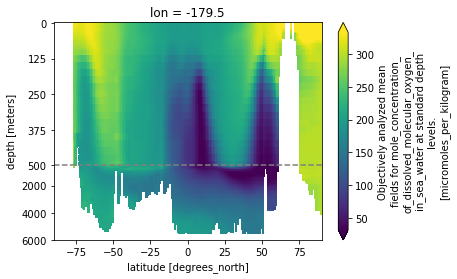

In [8]:
o2.sel(lon=-180, method='nearest').plot(robust=True)
ax = plt.gca()
ax.invert_yaxis()
linear_piecewise_scale(500, 20)
#indicate the point between the different scalings
ax.axhline(500, color='0.5', ls='--')
# Rearange the yticks
ax.set_yticks([0, 125, 250, 375, 500, 2000, 4000, 6000]);

We could also compress the upper ocean using the `scaled_half` argument. Here `upper` means values larger than `cut` are compressed and `lower` means values smaller than `cut` are compressed instead

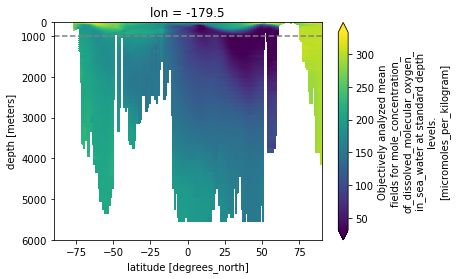

In [15]:
o2.sel(lon=-180, method='nearest').plot(robust=True)
ax = plt.gca()
ax.invert_yaxis()
linear_piecewise_scale(1000, 2, scaled_half='lower')
#indicate the point between the different scalings
ax.axhline(1000, color='0.5', ls='--')
# Rearange the yticks
ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000]);

You can apply all of the above to the x-axis as well, using th `axis` keyword.

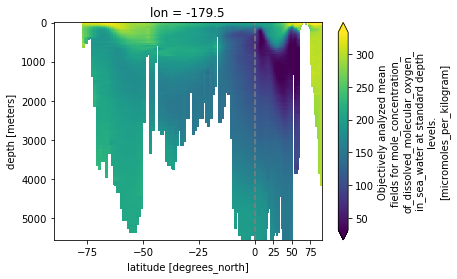

In [17]:
o2.sel(lon=-180, method='nearest').plot(robust=True)
ax = plt.gca()
ax.invert_yaxis()
linear_piecewise_scale(0, 2, axis='x')
#indicate the point between the different scalings
ax.axvline(0, color='0.5', ls='--')

This would put the focus on the southen hemisphere.

In [21]:
ax.get_xscale()

'function'